# Code-along 2025-01-15 Build an AI Movie Night Recommendation Tool


In this code-along, we will be building an AI Movie Night Recommendation Tool! 

To do this, we will be using two data sets: 
- Movies metadata: A data set containing metadata of about 9000 movies (title, description, etc.)
- User ratings: A data set containing ratings of how much someone liked a movie. 

We will be building towards our end goal by covering the following tasks: 
- Understanding the data set by doing some basic exploratory analysis 
- Building a first recommender based on movie popularity or movie ratings 
- Personalising recommendations by exploiting user ratings 
- Leveraging LLMs to calculate similarity between movies 
- Generating a recommendation by writing what kind of movies you'd like to see 
- Putting it all together into one single recommendation tool

This code-along is aimed at anyone just starting to code by showing how you can build something useful by simply writing prompts to analyse data sets. The code generated is sufficiently challenging, however, for the more seasoned data person to play around with.

## Task 1: Import the ratings and movie metadata and explore it. 

The data is contained in two CSV files named `movies_metadata.csv` and `ratings.csv`

`movies_metadata` contains the following columns: 

- `movie_id`: Unique identifier of each movie. 
- `title`: Title of the movie. 
- `overview`: Short description of the movie. 
- `vote_average`: Average score the movie got.
- `vote_count`: Total number of votes the movie got. 

`ratings` contains the following columns: 

- `user_id`: Unique identifier of the person who rated the movie. 
- `movie_id`: Unique identifier of the movie. 
- `rating`: Value between 0 and 10 indicating how much the person liked the movie. 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Read the movies_metadata file
movies_metadata = pd.read_csv('movies_metadata.csv')

# Read the ratings file
ratings = pd.read_csv('ratings.csv')

In [3]:
# Count how many unique movies there are
unique_movies = movies_metadata['movie_id'].nunique()

# Count how many unique users have rated how many unique movies
unique_users = ratings['user_id'].nunique()
unique_rated_movies = ratings['movie_id'].nunique()

print (f"number of unique movies:{unique_movies}")
print (f"number of unique users:{unique_users}")
print (f"number of unique user ratings:{unique_rated_movies}")

number of unique movies:9010
number of unique users:671
number of unique user ratings:9010


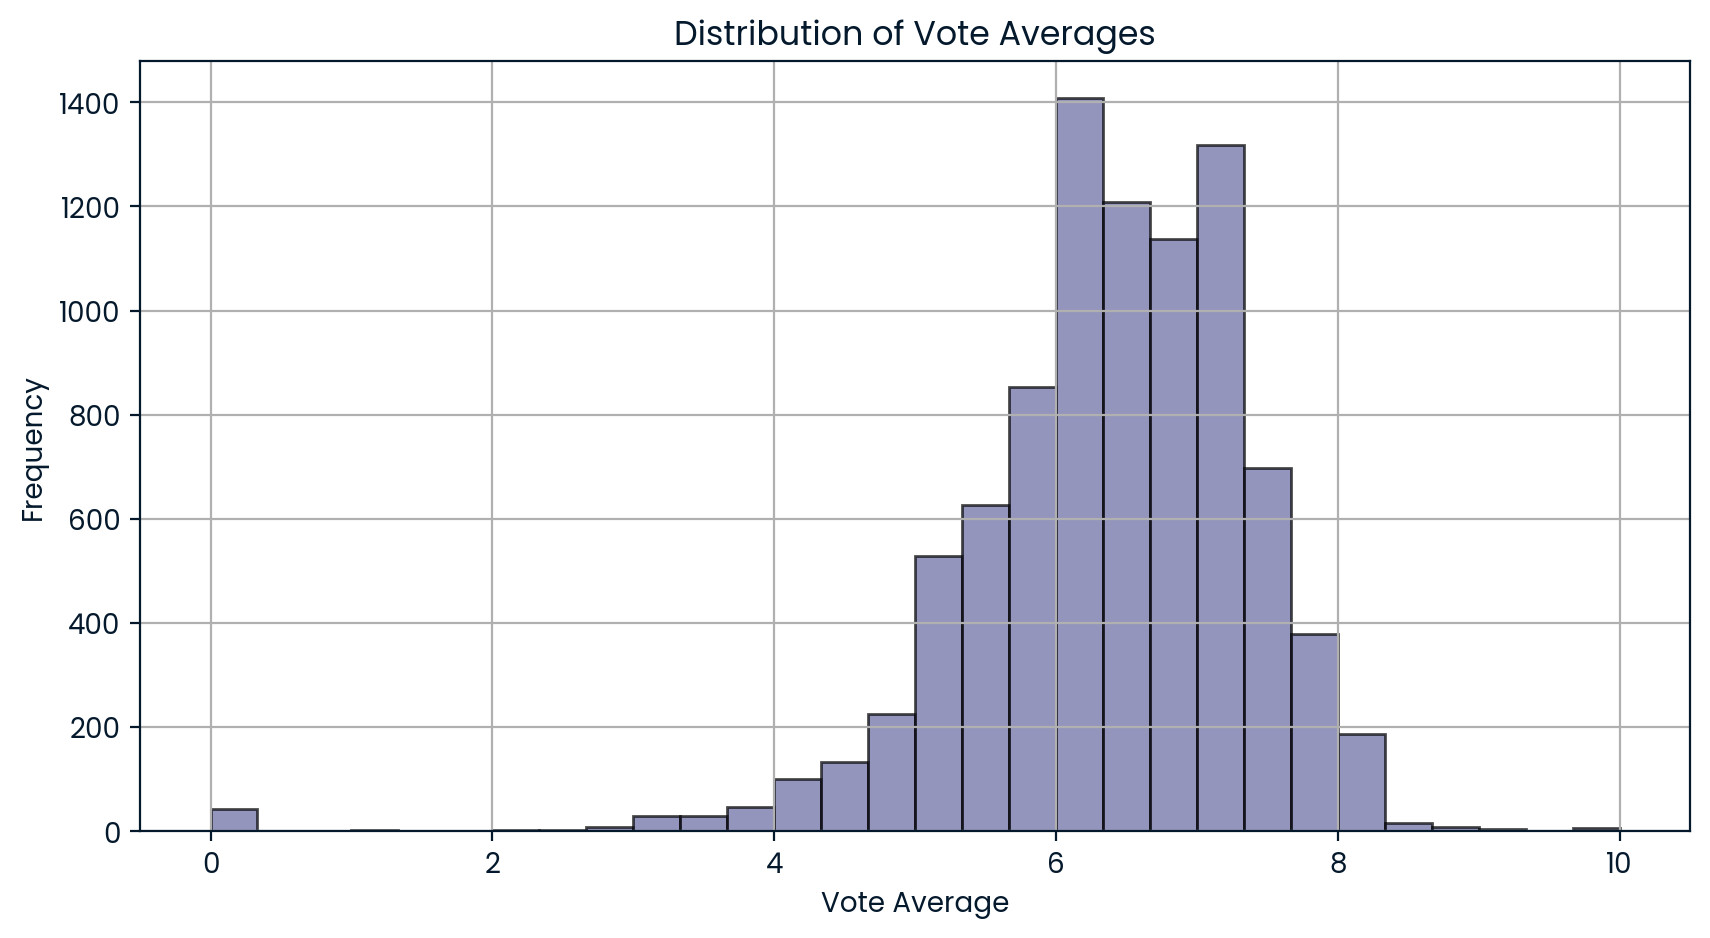

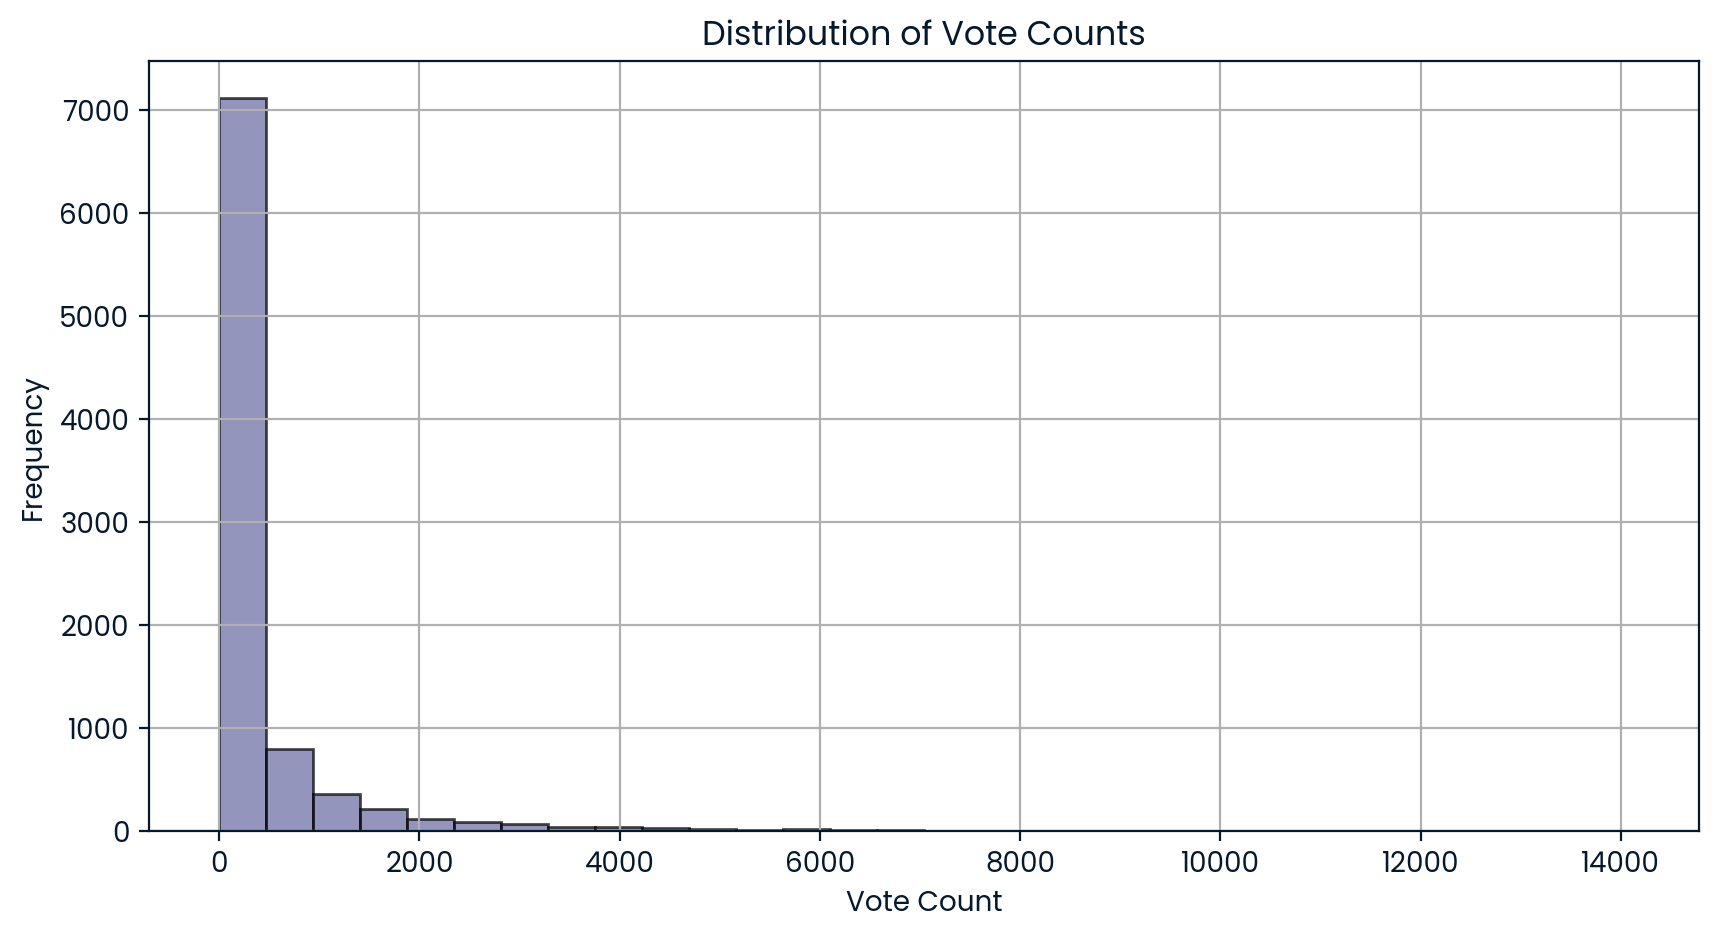

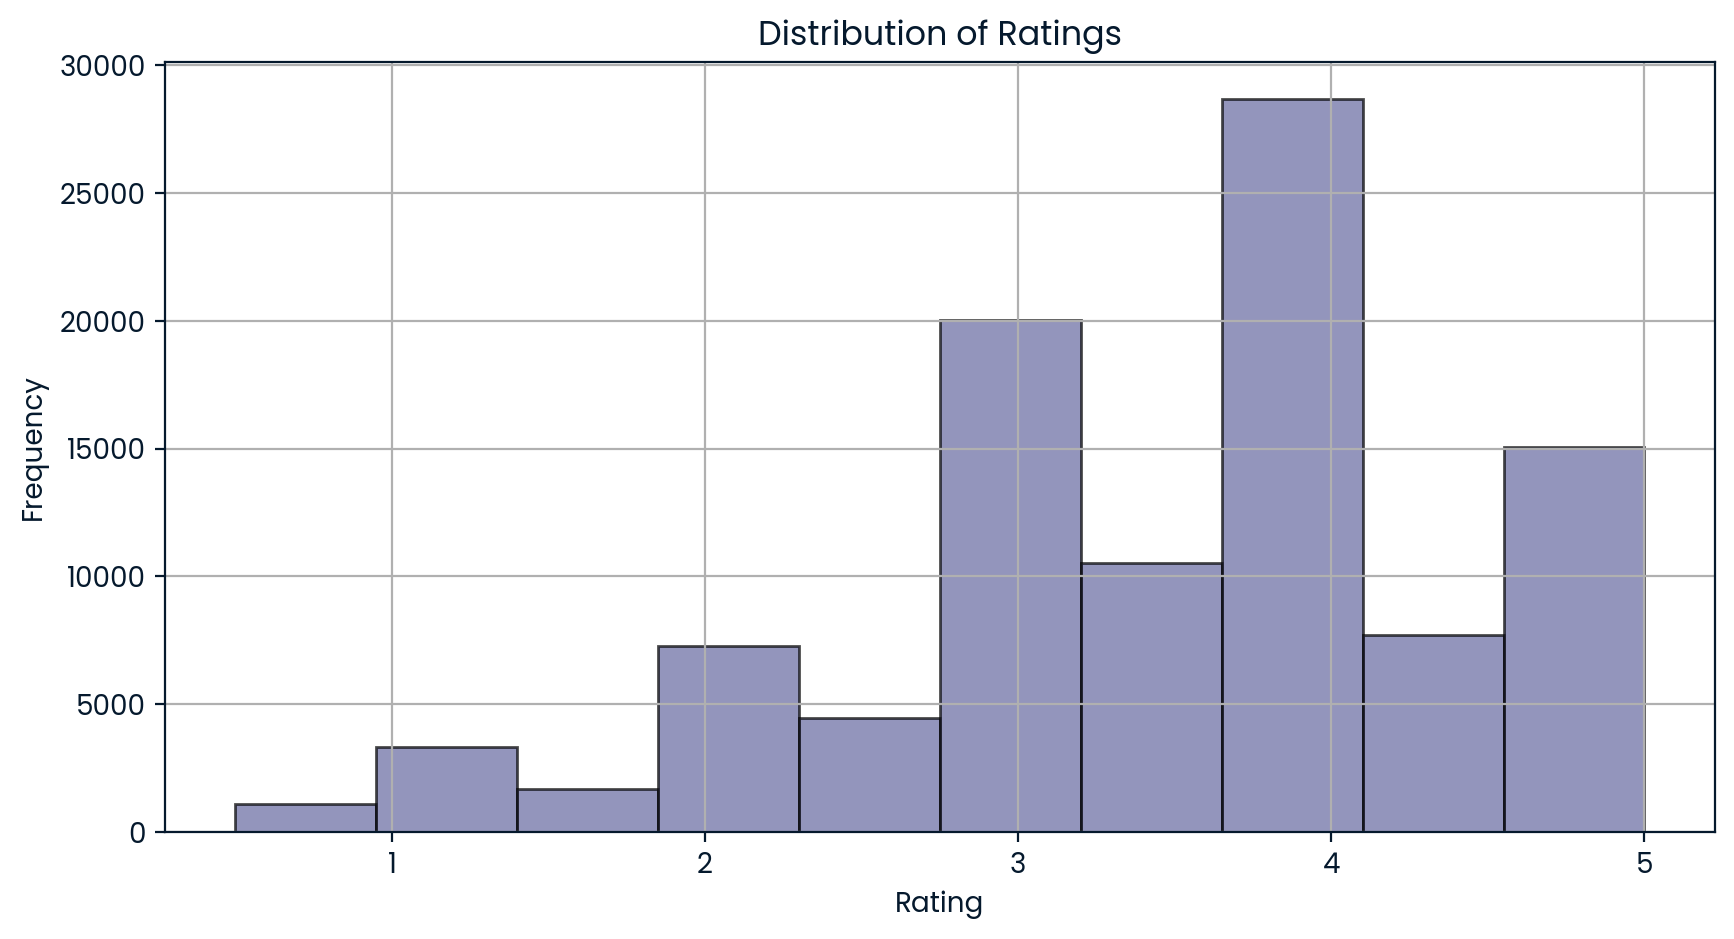

In [4]:
# Visualise the vote_average column
plt.figure(figsize=(10, 5))
plt.hist(movies_metadata['vote_average'].dropna(), bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Vote Averages')
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualise the vote_count column
plt.figure(figsize=(10, 5))
plt.hist(movies_metadata['vote_count'].dropna(), bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Vote Counts')
plt.xlabel('Vote Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualise the distribution of the rating column
plt.figure(figsize=(10, 5))
plt.hist(ratings['rating'].dropna(), bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Task 2: Simple recommender based on popularity or highest rating

In short, a recommender is any system that generates suggestions for an end user. We will start with creating the simplest recommender, one that ranks all movies according to the highest average score, or the highest number of votes. 

This kind of recommender generates the same output for anyone using it. 

In [5]:
def simple_recommender(movies_metadata, criterion='vote_average', top_n=10):
    
    if criterion not in ['vote_average', 'vote_count']:
        raise ValueError("Criterion must be either 'vote_average' or 'vote_count'")
    
    # Sort the movies based on the specified criterion
    recommended_movies = movies_metadata.sort_values(by=criterion, ascending=False)
    
    # Select the top N movies
    recommended_movies = recommended_movies.head(top_n)
    
    return recommended_movies[['movie_id','title','overview', criterion]]

In [6]:
simple_recommender(movies_metadata, criterion='vote_count', top_n=10)

,movie_id,title,overview,vote_count
67,1375666.0,Inception,"Cobb, a skilled thief who commits corporate es...",14075.0
5577,468569.0,The Dark Knight,Batman raises the stakes in his war on crime. ...,12269.0
5761,499549.0,Avatar,"In the 22nd century, a paraplegic Marine is di...",12114.0
8033,848228.0,The Avengers,When an unexpected enemy emerges and threatens...,12000.0
6935,1431045.0,Deadpool,Deadpool tells the origin story of former Spec...,11444.0
278,816692.0,Interstellar,Interstellar chronicles the adventures of a gr...,11187.0
6711,1853728.0,Django Unchained,"With the help of a German bounty hunter, a fre...",10297.0
1360,2015381.0,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...",10014.0
7828,137523.0,Fight Club,A ticking-time-bomb insomniac and a slippery s...,9678.0
4484,1392170.0,The Hunger Games,Every year in the ruins of what was once North...,9634.0


In [7]:
simple_recommender(movies_metadata, criterion='vote_average', top_n=10)

,movie_id,title,overview,vote_average
430,2751904.0,Survive and Advance,"In 1983, the NC State Wolfpack, coached by Jim...",10.0
2882,113270.0,"The Haunted World of Edward D. Wood, Jr.",The strange life and the wonderfully awful fil...,10.0
8907,114241.0,Reckless,"On Christmas eve, a relentlessly cheerful woma...",10.0
873,118925.0,"Dancer, Texas Pop. 81","Four guys, best friends, have grown up togethe...",10.0
6603,79278.0,Chilly Scenes of Winter,A man falls for a separated woman but can't co...,10.0
8363,109381.0,Carmen Miranda: Bananas Is My Business,A biography of the Portuguese-Brazilian singer...,10.0
7463,97099.0,Common Threads: Stories from the Quilt,"In the late 1970s, a mysterious new disease be...",10.0
1910,98769.0,The Civil War,This highly acclaimed mini series traces the c...,9.2
6136,81846.0,Cosmos,Astronomer Dr. Carl Sagan is host and narrator...,9.1
5441,2042520.0,Family Band: The Cowsills Story,"The story of the Cowsills, an American band co...",9.0


## Task 3: Generate recommendations based on user ratings

We already created a very simple first recommender, but we haven't touched our user data yet! How can this help us? When you watched a movie you liked, you might want to learn which other movies other users liked that also watched that movie. This is where the user data comes in. We can use the ratings to infer which movies are similar to a movie you have already watched! 

### Prompt
Create a recommender that uses the ratings data and generates movie recommendations when you put in a specific movie title.

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [9]:
def create_user_based_recommender(movies_metadata, ratings, movie_title, top_n=10):
    # Merge movies_metadata with ratings
    movie_ratings = pd.merge(ratings, movies_metadata, on='movie_id')

    # Create a pivot table with users as rows, movies as columns, and ratings as values
    user_movie_matrix = movie_ratings.pivot_table(index='user_id', columns='title', values='rating')

    # Fill NaN values with 0 (assuming unrated movies have a rating of 0)
    user_movie_matrix.fillna(0, inplace=True)

    # Compute the cosine similarity matrix
    movie_similarity = cosine_similarity(user_movie_matrix.T)

    # Convert the similarity matrix to a DataFrame
    movie_similarity_df = pd.DataFrame(movie_similarity, index=user_movie_matrix.columns, 
                                       columns=user_movie_matrix.columns)

    # Get the list of similar movies
    similar_movies = movie_similarity_df[movie_title].sort_values(ascending=False)[1:top_n+1]

    return similar_movies

In [10]:
movie_title = "The Godfather"
recommended_movies = create_user_based_recommender(movies_metadata, ratings, movie_title, top_n=10)
recommended_movies

title
The Godfather: Part II             0.773685
GoodFellas                         0.620349
One Flew Over the Cuckoo's Nest    0.568244
American Beauty                    0.557997
Star Wars                          0.546750
Raiders of the Lost Ark            0.538185
Saving Private Ryan                0.534684
Apocalypse Now                     0.534347
Reservoir Dogs                     0.531713
The Usual Suspects                 0.530727
Name: The Godfather, dtype: float64

## Task 4: Generate embeddings based on the movie descriptions

So far, we already created two recommenders! One that didn't take into account your preferences, and one that suggested movies based on similarity to a movie you already saw. Now, we will get creative and let you write a summary of the kind of move you'd like to watch to get recommendations back! 

In order to do this, we will rely on a concept called *embeddings*. In a nutshell, embeddings are numerical representations of a piece of text and they are critical to the success of the most recent generation of AI models, like ChatGPT. We will take the description of our movies and convert these to their embedded form. 

### Prompt
Take the overview field from movies_metadata. These are short descriptions from movies. Use a simple local llm model to generate embeddings for each movie 

In [1]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from tqdm import tqdm

In [2]:
# Load a pre-trained model from Sentence Transformers
model = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/211k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/368k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [7]:
# Ensure the 'overview' field is a string
movies_metadata['overview'] = movies_metadata['overview'].fillna('').astype(str)

# Generate embeddings for each movie overview
tqdm.pandas(desc="Generating embeddings")
movies_metadata['embedding'] = movies_metadata['overview'].progress_apply(lambda x: model.encode(x).tolist())

Generating embeddings: 100%|██████████| 9010/9010 [16:37<00:00,  9.03it/s]


## Task 5: Use embedding simillarity to generate recommendations

Now we are ready to create a new recommender function where we submit a description of a movie we want to watch and get recommendations back. 

### Prompt
Create a recommender that takes the embeddings in movies_metadata and a user-generated input that describes a movie they'd like to watch. Calculate the similarity between the embedding of that description with all movie embeddings and return the top n most similar movies.

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_movies(user_input, movies_metadata, model, top_n=5):
    # Generate embedding for the user input
    user_embedding = model.encode(user_input).tolist()
    
    # Calculate cosine similarity between user input embedding and all movie embeddings
    movies_metadata['similarity'] = movies_metadata['embedding'].apply(lambda x: cosine_similarity([user_embedding], [x])[0][0])
    
    # Sort movies by similarity in descending order and get the top n movies
    top_movies = movies_metadata.sort_values(by='similarity', ascending=False).head(top_n)
    
    return top_movies[['title', 'overview', 'similarity']]

In [9]:
# Example usage
user_input = "A story about a young wizard who discovers his magical heritage."
top_n = 5
recommended_movies = recommend_movies(user_input, movies_metadata, model, top_n)
recommended_movies

,title,overview,similarity
5579,The Wizard of Oz,Young Dorothy finds herself in a magical world...,0.516829
2556,Stardust,In a countryside town bordering on a magical l...,0.458553
7106,The Illusionist,"Scotland, late 1950s. A struggling illusionist...",0.455771
6378,The Raven,A magician who has been turned into a raven tu...,0.453578
5075,August Rush,"A drama with fairy tale elements, where an orp...",0.443685


## Task 6: Put it all together into a single function

In this final task, we will be putting all previous recommenders together into one single function that will allow you to generate an awesome movie night! 

### Prompt
Combine the three different recommenders we used before, the first one being a recommender based on vote_average or vote_count, the second one based on the ratings data where the most similar movies would be returned for a given movie title, and the third one being a recommender based on the movie embeddings that are most similar to a user-generated prompt. One of the three options should be returned.


In [10]:
def movie_night_recommender(df, method = 'popularity', criterion = None, user_input = None, model = None, top_n = 5): 
    if method == 'popularity': 
        return simple_recommender(df, criterion=criterion, top_n=top_n)
    elif method == 'rating_similarity': 
        return rating_recommender(movie_title = user_inpt, cosine_sim_df = df, num_recommendations = top_n) 
    elif method == 'movie_description': 
        return movie_description_recommender(user_input = user_input, movies_metadata = df, model = model, top_n=top_n) 
    else: 
        raise ValueError("Method must be one of: popularity, rating_similarity, or movie_description")